# A/B Test for MuscleHub
***

## Introduction

Like most businesses, keeps they're data in a SQL database. I have already downloaded the data from her database to a csv file, and will load it into a Jupyter Notebook using pandas to conduct A/B testing for the MuscleHub Gym.

Let's get started!

## Importing the dataset

MuscleHub has a SQLite database, which contains several tables that will be helpful  in this investigation. I have already created a csv file for each table.

In [33]:
import pandas as pd 
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # for creating wordclouds
from collections import Counter   #for counting objects
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure # to create a figure in matplotlib

In [2]:
applications = pd.read_csv("applications.csv")
applications.head()

,first_name,last_name,email,gender,application_date
0,Roy,Abbott,RoyAbbott32@gmail.com,male,2017-08-12
1,Agnes,Acevedo,AgnesAcevedo1@gmail.com,female,2017-09-29
2,Roberta,Acevedo,RA8063@gmail.com,female,2017-09-15
3,Darren,Acosta,DAcosta1996@hotmail.com,male,2017-07-26
4,Vernon,Acosta,VAcosta1975@gmail.com,male,2017-07-14


In [3]:
fitness_tests = pd.read_csv("fitness_tests.csv")
fitness_tests.head()

,first_name,last_name,email,gender,fitness_test_date
0,Kim,Walter,KimWalter58@gmail.com,female,2017-07-03
1,Tom,Webster,TW3857@gmail.com,male,2017-07-02
2,Marcus,Bauer,Marcus.Bauer@gmail.com,male,2017-07-01
3,Roberta,Best,RB6305@hotmail.com,female,2017-07-02
4,Carrie,Francis,CF1896@hotmail.com,female,2017-07-05


In [4]:
purchases = pd.read_csv("purchases.csv")
purchases.head()

,first_name,last_name,email,gender,purchase_date
0,Roy,Abbott,RoyAbbott32@gmail.com,male,2017-08-18
1,Roberta,Acevedo,RA8063@gmail.com,female,2017-09-16
2,Vernon,Acosta,VAcosta1975@gmail.com,male,2017-07-20
3,Darren,Acosta,DAcosta1996@hotmail.com,male,2017-07-27
4,Dawn,Adkins,Dawn.Adkins@gmail.com,female,2017-08-24


In [5]:
visits = pd.read_csv("visits.csv")
visits.head()

,first_name,last_name,email,gender,visit_date
0,Karen,Manning,Karen.Manning@gmail.com,female,5-1-17
1,Annette,Boone,AB9982@gmail.com,female,5-1-17
2,Salvador,Merritt,SalvadorMerritt12@outlook.com,male,5-1-17
3,Martha,Maxwell,Martha.Maxwell@gmail.com,female,5-1-17
4,Andre,Mayer,AndreMayer90@gmail.com,male,5-1-17


## Joining all the data

It would be helpful to have a single DataFrame with all of this data. 

A DataFrame containing all of this data. Not all visits in **visits.csv** occurred during the A/B test, only data where `visit_date` is on or after 7-1-17.


Columns needed:

* `visits.first_name`
* `visits.last_name`
* `visits.gender`
* `visits.email`
* `visits.visit_date`
* `fitness_tests.fitness_test_date`
* `applications.application_date`
* `purchases.purchase_date`

In [6]:
visits =  visits[visits["visit_date"] >= "7-1-17"]

In [7]:
df = visits.merge(fitness_tests, on=["first_name", "last_name", "email",  "gender"], how="left").merge(applications, on=["first_name", "last_name", "email", "gender"], how="left").merge(purchases, on=["first_name", "last_name", "email",  "gender"], how="left")
#df.head()
df.shape

(5004, 8)

## Visualize the Groups

Having compiled the DataFrame we can use to begin our project.

In [8]:
# Create new ab_test_group variable
df["AB_test_group"] = df.fitness_test_date.apply(lambda x: "A" if  pd.notnull(x) else "B")

In [9]:
# Obtain value counts of each group
df.AB_test_group.value_counts()

A    2504
B    2500
Name: AB_test_group, dtype: int64

In [10]:
# Obtain percentages of each group
df.AB_test_group.value_counts(normalize=True)

A    0.5004
B    0.4996
Name: AB_test_group, dtype: float64

In [11]:
fig = px.bar(df, "AB_test_group", title="AB test group", color="AB_test_group")
fig.show()

In [12]:
fig = px.pie(df, "AB_test_group", title="AB test group")
fig.show()

## Count of applications

The sign-up process for MuscleHub has several steps:

1. Take a fitness test with a personal trainer (only Group A).
2. Fill out an application for the gym.
3. Send in their payment for their first month's membership.

Determining the percentage of people in each group who complete Step 2, filling out an application.

In [13]:
# Create is_application variable
df["is_application"] = df.application_date.apply(lambda x: "Application"  if pd.notnull(x) else "No_Application")

In [14]:
# Create new app_counts DataFrame
app_counts = df.groupby(["AB_test_group", "is_application"]).first_name.count().reset_index()


In [15]:
app_pivot = pd.pivot_table(app_counts, index="AB_test_group",
                    columns=["is_application"], values='first_name').reset_index()
app_pivot

is_application,AB_test_group,Application,No_Application
0,A,250,2254
1,B,325,2175


In [16]:
# Create the total variable
app_pivot['Total'] = app_pivot.Application + app_pivot.No_Application
# Create the percent with application variable
app_pivot["Percent _with_Application"] = app_pivot.Application / app_pivot.Total
app_pivot

is_application,AB_test_group,Application,No_Application,Total,Percent _with_Application
0,A,250,2254,2504,0.09984
1,B,325,2175,2500,0.13000


It looks like more people from Group B turned in an application.  Why might that be?

We need to know if this difference is statistically significant.

## Calculate the statistical significance of applications

Having calculated the difference in who turned in an application between groups, we should think if this difference is statistically significant.

In [17]:
# Import hypothesis test module
from scipy.stats import chi2_contingency

# Calculate the p-value
contingency = [[250, 2254], [325, 2175]]
chi2_contingency(contingency)

(10.893961295282612,
 0.0009647827600722304,
 1,
 array([[ 287.72981615, 2216.27018385],
        [ 287.27018385, 2212.72981615]]))

A p-value of 0.00096 relative to a significance threshold of 0.05 indicates that there is a statistically signifant difference between the two groups.

## Detemine the count of memberships from applications

Of those who picked up an application, how many purchased a membership?

Determine how many potential customers purchased a membership out of those that picked up an application.

It looks like people who took the fitness test were more likely to purchase a membership if they picked up an application. Why might that be?

In [18]:
# Create an is_member variable
df["is_member"] = df.purchase_date.apply(lambda x: "member" if pd.notnull(x) else "not_member")

In [19]:
# Create the just_apps DataFrame
just_apps = df[df.is_application == "Application"]

In [20]:
# Create member_count DataFrame
member_count = just_apps.groupby(["AB_test_group", "is_member"]).first_name.count().reset_index()

In [21]:
# Pivot member_count
member_pivot = pd.pivot_table(member_count, index="AB_test_group", columns=["is_member"], values="first_name").reset_index()
# Create the Total variable
member_pivot["total"] = member_pivot.member + member_pivot.not_member
# Create the Percent Purchase variable
member_pivot["percent_purchase"] = member_pivot.member / member_pivot.total
member_pivot

is_member,AB_test_group,member,not_member,total,percent_purchase
0,A,200,50,250,0.800000
1,B,250,75,325,0.769231


It looks like people who took the fitness test were more likely to purchase a membership if they picked up an application.  Why might that be?

## Calculate the statistical significance of memberships

Calculate if the difference between the following groups is statistically significant: 
- The customers that picked up an application and took a fitness test.
- The customers that did not take a fitness test and picked up an application.

In [22]:
# Calculate the p-value
contingency = [[200, 50], [250, 75]]
chi2_contingency(contingency)

(0.615869230769231,
 0.43258646051083327,
 1,
 array([[195.65217391,  54.34782609],
        [254.34782609,  70.65217391]]))

A p-value of 0.432 relative to a significance threshold of 0.05 does not reflect a statistically significant difference between the two groups, and would lead us to fail to reject the null hypothesis.

## Detemine the count of all memberships

Previously, we looked at what percentage of people who picked up applications purchased memberships. 

What percentage of ALL visitors purchased memberships.?

In [23]:
# Create final_member_count DataFrame
all_memberships = df.groupby(['AB_test_group', 'is_member']).first_name.count().reset_index()
# Pivot final_member_count
all_memberships_pivot = all_memberships.pivot(index="AB_test_group", columns="is_member", values="first_name").reset_index()
all_memberships_pivot
# Create the Total variable
all_memberships_pivot["total"] = all_memberships_pivot.member + all_memberships_pivot.not_member
# Create the Percent Purchase variable
all_memberships_pivot["total_percent"] = all_memberships_pivot.member / all_memberships_pivot.total
all_memberships_pivot

is_member,AB_test_group,member,not_member,total,total_percent
0,A,200,2304,2504,0.079872
1,B,250,2250,2500,0.100000


Previously, when we only considered people who had already picked up an application, we saw that there was no significant difference in membership between Group A and Group B.

Now, when we consider all people who visit MuscleHub, we see that there might be a significant difference in memberships between Group A and Group B.

## Calculate the statistical significance between groups

Determine if there is a significant difference in memberships between Group A and Group B.

In [24]:
# Calculate the p-value
contingency = [[200, 2304], [250, 2250]]
chi2_contingency(contingency)

(5.949182292591156,
 0.014724114645783203,
 1,
 array([[ 225.17985612, 2278.82014388],
        [ 224.82014388, 2275.17985612]]))

A p-value of 0.0147 relative to a significance threshold of 0.05 indicates that there is a statistically significant difference between the two groups. This informs us that we should not reject the hypothesis that visitors assigned to Group B will be more likely to eventually purchase a membership to MuscleHub than visitors assigned to Group A.

However, it is important to note that when assessing the groups among those customers that filled out an application, those that completed a fitness test (Group A), were more likely to make a purchase than those customers that did not complete a fitness test (Group B).

## Visualize the results

The difference between Group A (people who were given the fitness test) and Group B (people who were not given the fitness test) at each state of the process:

- Percent of visitors who apply.
- Percent of applicants who purchase a membership.
- Percent of visitors who purchase a membership.

In [25]:
fig = px.bar(app_pivot, y="Percent _with_Application", x="AB_test_group", color="AB_test_group", title='Percent of visitors who apply')
for data in fig['data']:
        data.width = 0.5
fig.update_layout(title_x=0.5, yaxis = dict(tickmode = 'array', tickvals = [0, 0.05, 0.10, 0.15, 0.20], ticktext = ['0%', '5%', '10%', '15%', '20%']), xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1],
        ticktext =  ["Fitness Test", "No Fitness Test"]), yaxis_title=None, xaxis_title=None)
fig.show()

In [26]:
fig = px.bar(member_pivot, y="percent_purchase", x="AB_test_group", color="AB_test_group", title="Percent of applicants who purchase a membership.")
for data in fig['data']:
        data.width = 0.5
fig.update_layout(title_x=0.5, yaxis = dict(tickmode = 'array', tickvals = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], ticktext = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']),  xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1],
        ticktext =  ["Fitness Test", "No Fitness Test"]), yaxis_title=None, xaxis_title=None)
fig.show()

In [27]:
fig = px.bar(all_memberships_pivot, y="total_percent", x="AB_test_group", color="AB_test_group", title='Percent of visitors who purchase a membership.')
for data in fig['data']:
        data.width = 0.5
fig.update_layout(title_x=0.5, yaxis = dict(tickmode = 'array', tickvals = [0, 0.05, 0.10, 0.15, 0.20], ticktext = ['0%', '5%', '10%', '15%', '20%']), xaxis = dict(
        tickmode = 'array',
        tickvals = [0, 1],
        ticktext =  ["Fitness Test", "No Fitness Test"]), yaxis_title=None, xaxis_title=None)
fig.show()

Creating a [wordcloud](https://pypi.org/project/wordcloud/) visualization that can be use to create an ad for the MuscleHub Gym with the data in `interviews.txt`. 

In [28]:
# Open and read the interviews.txt file
interviews = open(r"interviews.txt", encoding='utf8')
txtContent = interviews.read()
print ("The Content of text file is : ", txtContent)

The Content of text file is :  I always wanted to work out like all of the shredded people on the fitness accounts I see on Instagram, but I never really knew how to start. MuscleHub’s introductory fitness test was super helpful for me! After taking the fitness test, I had to sign up and keep coming back so that I could impress my trainer Rachel with how much I was improving!
- Cora, 23, Hoboken

When I walked into MuscleHub I wasn’t accosted by any personal trainers trying to sell me some mumbo jumbo, which I really appreciated. Down at LiftCity they had me doing burpees 30 seconds after I walked in the door and I was like “woah guys slow your roll, this is TOOOO much for Jesse!” I still ended up not signing up for a membership because the weight machines had all those sweat stains on them and you know, no thanks.
- Jesse, 35, Gowanes

I took the MuscleHub fitness test because my coworker Laura recommended it. Regretted it.
- Sonny "Dad Bod", 26, Brooklyn

I saw an ad for MuscleHub on

In [29]:
# Print the length of the new string
print('There are {} words in the total interviews.txt file.'.format(len(txtContent)))

There are 1293 words in the total interviews.txt file.


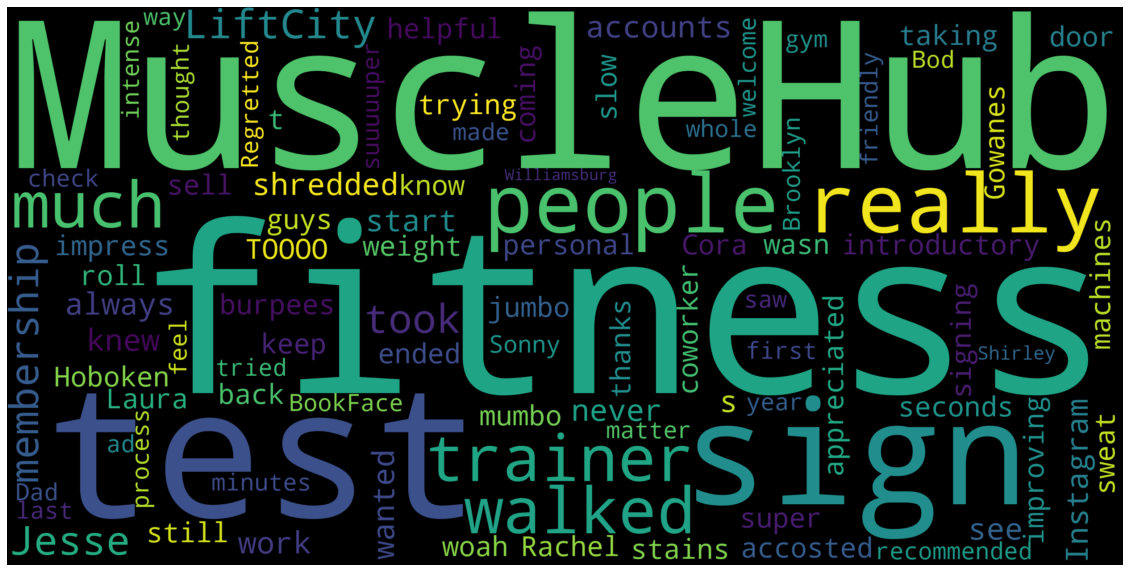

In [34]:
# Create a wordcloud object
wordcloud = WordCloud(width=2500, height=1250).generate(txtContent)

# Display the wordcloud with MatplotLib and save figure
figure(num=None, figsize=(20, 16), facecolor='w', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()